Importing necessary libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import cross_val_score

Importing our datasets

In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving test.csv to test (3).csv
Saving train.csv to train (3).csv
User uploaded file "test.csv" with length 451405 bytes
User uploaded file "train.csv" with length 460676 bytes


Preparing our dataset,
Merging Train and Test into one

In [0]:
kaggle_train = pd.read_csv('train.csv') 
kaggle_test = pd.read_csv('test.csv')
da=pd.concat([kaggle_train,kaggle_test]).reset_index()

In [0]:
noSalePrice = [a for a in da.columns if a!='SalePrice']
da[noSalePrice] = da[noSalePrice].fillna(da[noSalePrice].mean())

Dealing with NaNs of numerical variables

Lets see and delete outliers associated with independent variables i.e, OverallQual, GrLivArea, TotalBsmtSF..
Because Outliers are exceptional data which disturb us to design a model based on data which follows a pattern

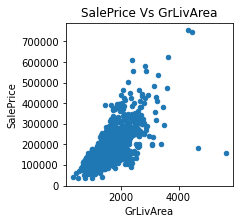

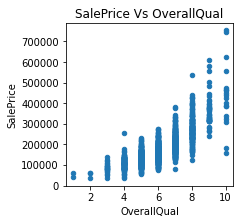

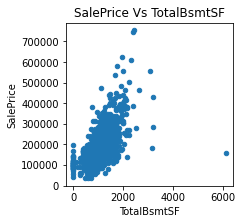

In [0]:
da.plot.scatter(x='GrLivArea',y='SalePrice',title='SalePrice Vs GrLivArea',figsize=(3,3));
da.plot.scatter(x='OverallQual',y='SalePrice',title='SalePrice Vs OverallQual',figsize=(3,3));
da.plot.scatter(x='TotalBsmtSF',y='SalePrice',title='SalePrice Vs TotalBsmtSF',figsize=(3,3));

Lets remove the outliers which disturbs our predictions

In [0]:
da.drop(da[(da['SalePrice']<250000)&(da['GrLivArea']>4000)].index,inplace=True)
da.drop(da[(da['SalePrice']<500000)&(da['TotalBsmtSF']>3000)].index,inplace=True)
da.drop(da[(da['SalePrice']>700000)&(da['TotalBsmtSF']>2000)].index,inplace=True)
da.drop(da[(da['SalePrice']>200000)&(da['OverallQual']==4)].index,inplace=True)
da.drop(da[(da['SalePrice']>500000)&(da['OverallQual']==8)].index,inplace=True)

These are plots after removing outliers

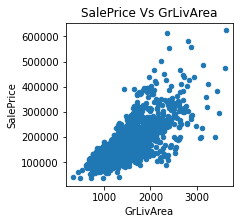

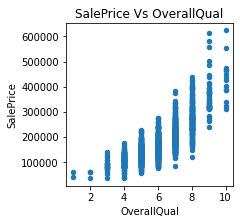

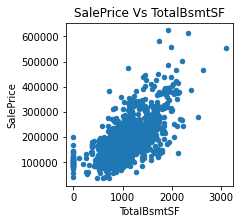

In [0]:
da.plot.scatter(x='GrLivArea',y='SalePrice',title='SalePrice Vs GrLivArea',figsize=(3,3));
da.plot.scatter(x='OverallQual',y='SalePrice',title='SalePrice Vs OverallQual',figsize=(3,3));
da.plot.scatter(x='TotalBsmtSF',y='SalePrice',title='SalePrice Vs TotalBsmtSF',figsize=(3,3));

We design a list of ind_vars which is a guess that SalePrice mostly depends on these data, Taking many vars will make our model overfitted, So lets use only some of them

In [0]:
ind_vars=['OverallCond','GrLivArea', 'TotalBsmtSF','GarageArea','YearBuilt','OverallQual','GarageCars']

Lets check VIFs to get a clarity of how good our ind_vars are

In [0]:
from patsy import dmatrices
Y, X = dmatrices('SalePrice ~ GrLivArea+TotalBsmtSF+OverallQual+GarageArea+YearBuilt+OverallCond+GarageCars', da, return_type='dataframe')
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,8753.636009,Intercept
1,1.762274,GrLivArea
2,1.536368,TotalBsmtSF
3,2.656782,OverallQual
4,4.846000,GarageArea
5,2.092689,YearBuilt
6,1.228420,OverallCond
7,5.338542,GarageCars


In [0]:
dac = da[['SalePrice','OverallCond','GrLivArea', 'TotalBsmtSF','GarageArea','YearBuilt','OverallQual','GarageCars']].corr()
dac[['SalePrice']][1:]

,SalePrice
OverallCond,-0.078134
GrLivArea,0.715647
TotalBsmtSF,0.645359
GarageArea,0.637877
YearBuilt,0.536851
OverallQual,0.805036
GarageCars,0.650657


This list has been modified by checking VIFs, corr values..
So lets use these to predict SalePrice

In [0]:
da['SalePrice'] = np.log1p(da['SalePrice'])

By using this we can reduce skewness

In [0]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(da[:1452][ind_vars],da[:1452]['SalePrice'],test_size=0.33,random_state=42)

Dividing our train dataset to feed and check our model by using train_test_split function

## **LinearRegression**

In [0]:
model=LinearRegression()
model.fit(Xtrain,Ytrain)
Ypred1=model.predict(Xtest)
dff=pd.DataFrame({"Predicted Values":np.expm1(Ypred1),"     Values should have been predicted":np.expm1(Ytest.tolist())})
print(dff.head())

   Predicted Values       Values should have been predicted
0     183247.414373                                196000.0
1     122139.132121                                135000.0
2     196484.835638                                136905.0
3     293876.935307                                147000.0
4      43374.796161                                 39300.0


As we are working with more independent variables, its better to use adjusted r2, not much difference by the way

In [0]:
def adjusted_r2(Xtest,r2):
  n=len(Xtest)
  p=len(Xtest.columns)
  a_r2=1 - (1-r2)*(n-1)/(n-p-1)
  return a_r2
R2_1=r2_score(Ytest,Ypred1)
adj_r2_1=adjusted_r2(Xtest,R2_1)
print("R2 value : {}".format(R2_1))
print("Adjusted R2 value : {}".format(adj_r2_1))
print("MSE : {}".format(sqrt(mean_squared_error(Ytest,Ypred1))))

R2 value : 0.8719487474785019
Adjusted R2 value : 0.8700496822928018
MSE : 0.14481192390706368


### LassoCV

In [0]:
def adjusted_r2(Xtest,r2):
  n=len(Xtest)
  p=len(Xtest.columns)
  a_r2=1 - (1-r2)*(n-1)/(n-p-1)
  return a_r2
Ls1=LassoCV()
Ls1.fit(Xtrain,Ytrain)
Ypred2=Ls1.predict(Xtest)
R2_2=r2_score(Ytest,Ypred2)
adj_r2_2=adjusted_r2(Xtest,R2_2)
print("R2 value : {}".format(R2_2))
print("Adjusted R2 value : {}".format(adj_r2_2))
print("Error : {}".format(sqrt(mean_squared_error(Ytest,Ypred2))))

R2 value : 0.8182172036551459
Adjusted R2 value : 0.8155212723534214
Error : 0.1725396043897892


### RidgeCV

In [0]:
Rr=RidgeCV()
Rr.fit(Xtrain,Ytrain)
Ypred3=Rr.predict(Xtest)
R2_3=r2_score(Ytest,Ypred3)
adj_r2_3=adjusted_r2(Xtest,R2_3)
print("R2 value : {}".format(R2_3))
print("Adjusted R2 value : {}".format(adj_r2_3))
print("Error : {}".format(sqrt(mean_squared_error(Ytest,Ypred3))))

R2 value : 0.8720429942481427
Adjusted R2 value : 0.8701453267899584
Error : 0.14475862271726767


### ElasticNetCV

In [0]:
EN1 = ElasticNetCV(l1_ratio=np.linspace(0.1, 1.0, 5))
EN1.fit(Xtrain,Ytrain)
Ypred4=EN1.predict(Xtest)
R2_4=r2_score(Ytest,Ypred4)
adj_r2_4=adjusted_r2(Xtest,R2_4)
print("R2 value : {}".format(R2_4))
print("Adjusted R2 value : {}".format(adj_r2_4))
print("Error : {}".format(sqrt(mean_squared_error(Ytest,Ypred4))))

R2 value : 0.8182172036551459
Adjusted R2 value : 0.8155212723534214
Error : 0.1725396043897892


By observing Errors and R2 values, we come to a conclusion to use RidgeCV model

Converting our submission into submittable format

In [0]:
x=da[1452:].drop(['SalePrice'],axis=1)
sub=pd.DataFrame({'Id':x.Id,'SalePrice':np.expm1(Rr.predict(x[ind_vars]))})
sub.to_csv('final_submission.csv',index=False)
from google.colab import files
files.download('final_submission.csv')

Thereby Submitting our predictions

References:

https://www.kaggle.com/duverj/tutorial-linear-regression
https://www.kaggle.com/rbyron/simple-linear-regression-models

